<a href="https://colab.research.google.com/github/45sajal/NLP_project/blob/main/Natural_Language_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#we're going to be replicating the deep learning model behind the 2017 paper PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts.

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 15.28 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt


In [5]:
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
import os
filenames=[data_dir+ filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [7]:
# preprocess data

In [8]:
def get_lines(filename):
  with open(filename,'r') as f:
    return f.readlines()

In [9]:
train_lines=get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [11]:
train_samples=preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples=preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples=preprocess_text_with_line_numbers(data_dir+"test.txt")

print(len(train_samples))
print(len(val_samples))
print(len(test_samples))

180040
30212
30135


In [12]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)

In [13]:
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [14]:
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

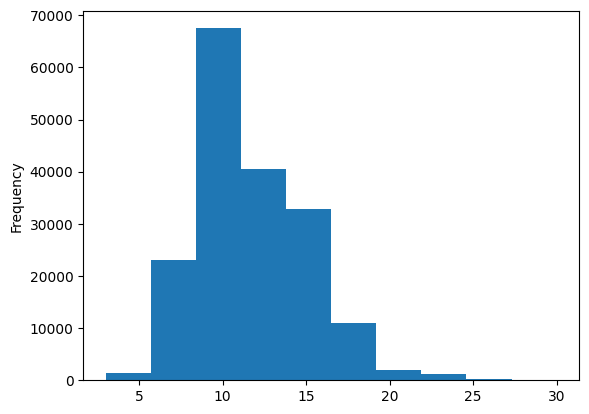

In [15]:
train_df["total_lines"].plot.hist()

In [16]:
train_sentences=train_df["text"].tolist()
val_sentences=val_df["text"].tolist()
test_sentences=test_df["text"].tolist()

In [17]:
## making numeric labels

In [18]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse_output=False)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

In [19]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded=label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded=label_encoder.transform(test_df["target"].to_numpy())

In [20]:
#model 0

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
model_0=Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])

model_0.fit(X=train_sentences,y=train_labels_encoded)


Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
model_0.score(val_sentences,val_labels_encoded)

0.7218323844829869

In [23]:
baseline_preds=model_0.predict(val_sentences)

In [24]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-10 15:10:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-10 15:10:38 (110 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [26]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  from sklearn.metrics import accuracy_score,precision_recall_fscore_support
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [27]:
baseline_results=calculate_results(val_labels_encoded,baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [28]:
# preparing our data for deep learning

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [30]:
# how long is each sentence on average
sent_lens=[len(sentence.split()) for sentence in train_sentences]
avg_sent_len=np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

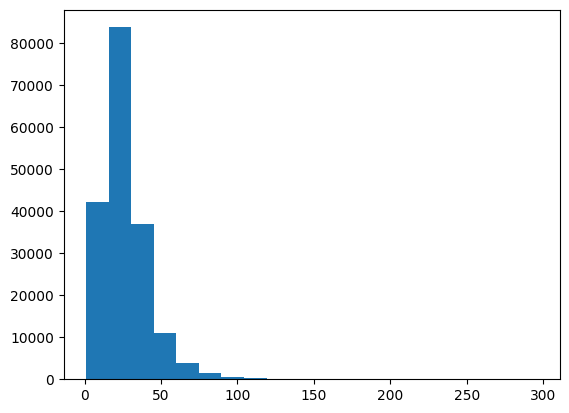

In [31]:
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=20)

In [32]:
# how long of a sentence length covers 95% percent of the data
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len

55

In [33]:
# maxlen
max(sent_lens)

296

In [34]:
max_token=68000

In [35]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer=TextVectorization(max_tokens=max_token, # no of words in the vocablury
                                  output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [36]:
text_vectorizer.adapt(train_sentences)

In [37]:
import random
target_sentence=random.choice(train_sentences)
print(f"text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\n vectorized version:{text_vectorizer([target_sentence])}")

text:
yoga training program included the @ principles of slow motions ( hatayoga ) , respiratory exercises ( pranayama ) and centralization to control mind via meditation , expansion and stasis ( rajayoga ) .

Length of text: 34

 vectorized version:[[ 1869   155   256   121     2  4414     4  2406 20145 56515   589  1111
  35418     3 40387     6    35  6278   598  5344  4382     3  9047 47358
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [38]:
rct_20k_text_vocab=text_vectorizer.get_vocabulary() # get all the unique words in our training data
print("most common words ",rct_20k_text_vocab[:5])
print("least common words ",rct_20k_text_vocab[-5:])
print("no of total words ",len(rct_20k_text_vocab))

most common words  ['', '[UNK]', 'the', 'and', 'of']
least common words  ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']
no of total words  64841


In [39]:
token_embed=layers.Embedding(input_dim=len(rct_20k_text_vocab),
                             output_dim=128, # different embedding sizes result in drastically different no of parameters to train
                             mask_zero=True, # use masking to handle variable sequence lengths # efficient computing when there a lot of 0's
                             name="token_embedding")

In [40]:
print(f"before vectorization {target_sentence}")
vectorized_sentence=text_vectorizer([target_sentence])
print(f"after vectorization {vectorized_sentence}")
embedded_sentence=token_embed(vectorized_sentence)
print(f"after embedding {embedded_sentence}")
print(f"after embedding shape {embedded_sentence.shape}")

before vectorization yoga training program included the @ principles of slow motions ( hatayoga ) , respiratory exercises ( pranayama ) and centralization to control mind via meditation , expansion and stasis ( rajayoga ) .
after vectorization [[ 1869   155   256   121     2  4414     4  2406 20145 56515   589  1111
  35418     3 40387     6    35  6278   598  5344  4382     3  9047 47358
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
after embedding [[[ 0.00750326  0.04071832  0.02256492 ...  0.02756674  0.02200072
   -0.01717186]
  [-0.01134353  0.04844942  0.04375624 ... -0.00272296  0.00823476
   -0.00313506]
  [-0.01632835 -0.01665419  0.0303751  ...  0.04429969  0.00017618
    0.02732328]
  ...
  [ 0.02252749  0.03796363 -0.03630254 ... -0.04609741  0.01373807
   -0.02170444]
  [ 0.02252749  0.03796363 -0.03630254 ... -0.04609741  0.01

In [41]:
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
val_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

In [42]:
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [43]:
# conv1D

In [44]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
text_vectors=text_vectorizer(inputs)
token_embeddings=token_embed(text_vectors)
x=layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(5,activation="softmax")(x)
model_1=tf.keras.Model(inputs,outputs)



In [45]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
history_model_1=model_1.fit(train_dataset,steps_per_epoch=int(0.1*len(train_dataset)),epochs=3,validation_data=val_dataset,
                            validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 46s 60ms/step - loss: 0.9073 - accuracy: 0.6411 - val_loss: 0.6846 - val_accuracy: 0.7384
Epoch 2/3
562/562 [==============================] - 9s 15ms/step - loss: 0.6576 - accuracy: 0.7568 - val_loss: 0.6296 - val_accuracy: 0.7696
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6164 - accuracy: 0.7764 - val_loss: 0.5942 - val_accuracy: 0.7842


In [46]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5962 - accuracy: 0.7865


[0.5962353944778442, 0.7864755988121033]

In [47]:
model_1_pred_probs=model_1.predict(val_dataset)

945/945 [==============================] - 3s 3ms/step


In [48]:
model_1_preds=tf.argmax(model_1_pred_probs,axis=1)

In [49]:
model_1_results=calculate_results(val_labels_encoded,model_1_preds)
model_1_results

{'accuracy': 78.64755726201508,
 'precision': 0.7832532630879134,
 'recall': 0.7864755726201509,
 'f1': 0.7839373930016054}

In [50]:
# model 2 feature extraction with pretrained token embeddings

In [51]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [52]:
random_training_sentence=random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence=tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
in spite of barriers , public-private collaboration resulted in significantly higher influenza immunization rates , particularly for older , healthy children who visit providers less frequently .

Sentence after embedding:
[-0.05883164  0.05794216  0.00735633 -0.07463267 -0.07941519  0.07067158
  0.04511291 -0.0542095  -0.0304675   0.02058502  0.08474763  0.00867409
 -0.0311621  -0.02615649  0.03244651  0.04875315 -0.08914357 -0.00353582
 -0.0119428  -0.05753494  0.04283293  0.02176291 -0.01823406  0.06037249
  0.04475064  0.04725061 -0.01309084  0.01498656 -0.01765936 -0.05609139] (truncated output)...

Length of sentence embedding:
512


In [53]:
# model 2

In [54]:
inputs=layers.Input(shape=[],dtype=tf.string)
pretrained_embedding=tf_hub_embedding_layer(inputs) # tokenize and create embeddiing of each sequence
x=layers.Dense(128,activation="relu")(pretrained_embedding)
#NOTE: we could also add more layers if needed
outputs=layers.Dense(5,activation="softmax")(x)
model_2=tf.keras.Model(inputs,outputs,name="model_2_USE")

In [55]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
history_model_2=model_2.fit(train_dataset,steps_per_epoch=int(0.1*len(train_dataset)),epochs=3,validation_data=val_dataset,
                            validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9190 - accuracy: 0.6494 - val_loss: 0.7971 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 9s 15ms/step - loss: 0.7686 - accuracy: 0.7018 - val_loss: 0.7545 - val_accuracy: 0.7021
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7509 - accuracy: 0.7133 - val_loss: 0.7383 - val_accuracy: 0.7141


In [56]:
model_2.evaluate(val_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.7407 - accuracy: 0.7136


[0.7407305240631104, 0.7135906219482422]

In [57]:
model_2_pred_probs=model_2.predict(val_dataset)

945/945 [==============================] - 10s 10ms/step


In [58]:
model_2_preds=tf.argmax(model_2_pred_probs,axis=1)

In [59]:
model_2_results=calculate_results(val_labels_encoded,model_2_preds)
model_2_results

{'accuracy': 71.35906262412286,
 'precision': 0.7138612625100351,
 'recall': 0.7135906262412286,
 'f1': 0.7104629354018037}

In [60]:
# model3 Conv1D with character embeddings

In [61]:
def split_chars(text):
  return " ".join(list(text))

In [62]:
split_chars(random_training_sentence)

'i n   s p i t e   o f   b a r r i e r s   ,   p u b l i c - p r i v a t e   c o l l a b o r a t i o n   r e s u l t e d   i n   s i g n i f i c a n t l y   h i g h e r   i n f l u e n z a   i m m u n i z a t i o n   r a t e s   ,   p a r t i c u l a r l y   f o r   o l d e r   ,   h e a l t h y   c h i l d r e n   w h o   v i s i t   p r o v i d e r s   l e s s   f r e q u e n t l y   .'

In [63]:
train_chars=[split_chars(sentence) for sentence in train_sentences]
val_chars=[split_chars(sentence) for sentence in val_sentences]
test_chars=[split_chars(sentence) for sentence in test_sentences]

In [64]:
char_lens=[len(sentence) for sentence in train_sentences]
mean_char_len=np.mean(char_lens)
mean_char_len

149.3662574983337

In [65]:
output_seq_char_len=int(np.percentile(char_lens,95))
output_seq_char_len

290

In [66]:
import string
alphabet=string.ascii_lowercase + string.digits + string.punctuation

In [67]:
NUM_CHAR_TOKENS=len(alphabet)+2 # add 2 for space and OOV(out of vocab)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")


In [68]:
char_vectorizer.adapt(train_chars)

In [69]:
char_vocab=char_vectorizer.get_vocabulary()

In [70]:
print("most common words ",char_vocab[:5])
print("least common words ",char_vocab[-5:])
print("no of total words ",len(char_vocab))

most common words  ['', '[UNK]', 'e', 't', 'i']
least common words  ['k', 'x', 'z', 'q', 'j']
no of total words  28


In [71]:
random_train_chars=random.choice(train_chars)
random_train_chars

't h e   r e l a t i o n s h i p   b e t w e e n   t h e   e f f e c t i v e n e s s   o f   f l u o x e t i n e   t r e a t m e n t   a n d   s e r o t o n i n   t r a n s p o r t e r   g e n o t y p e   w i l l   a l s o   b e   e x p l o r e d   .'

In [72]:
vectorized_chars=char_vectorizer([random_train_chars])
vectorized_chars

<tf.Tensor: shape=(1, 290), dtype=int64, numpy=
array([[ 3, 13,  2,  8,  2, 12,  5,  3,  4,  7,  6,  9, 13,  4, 14, 22,
         2,  3, 20,  2,  2,  6,  3, 13,  2,  2, 17, 17,  2, 11,  3,  4,
        21,  2,  6,  2,  9,  9,  7, 17, 17, 12, 16,  7, 24,  2,  3,  4,
         6,  2,  3,  8,  2,  5,  3, 15,  2,  6,  3,  5,  6, 10,  9,  2,
         8,  7,  3,  7,  6,  4,  6,  3,  8,  5,  6,  9, 14,  7,  8,  3,
         2,  8, 18,  2,  6,  7,  3, 19, 14,  2, 20,  4, 12, 12,  5, 12,
         9,  7, 22,  2,  2, 24, 14, 12,  7,  8,  2, 10,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 

In [73]:
char_embed=layers.Embedding(input_dim=len(char_vocab),
                            output_dim=25, # this is the char embedding in the paper
                            mask_zero=True,
                            name="char_embed")


In [74]:
print(f"chrified text:\n{random_train_chars}")
char_embed_example=char_embed(char_vectorizer([random_train_chars]))
print(f"embedding text:\n{char_embed_example}")

chrified text:
t h e   r e l a t i o n s h i p   b e t w e e n   t h e   e f f e c t i v e n e s s   o f   f l u o x e t i n e   t r e a t m e n t   a n d   s e r o t o n i n   t r a n s p o r t e r   g e n o t y p e   w i l l   a l s o   b e   e x p l o r e d   .
embedding text:
[[[ 0.01763545  0.04993607 -0.01232501 ... -0.03367763  0.04320468
    0.0258359 ]
  [ 0.00327431 -0.01279391  0.01698828 ...  0.04711806 -0.00831372
   -0.04975759]
  [ 0.00211696  0.02882436 -0.03808039 ... -0.03201018 -0.04669917
   -0.00852816]
  ...
  [-0.02309654 -0.04660013 -0.04044262 ...  0.03816135  0.01934173
   -0.04587511]
  [-0.02309654 -0.04660013 -0.04044262 ...  0.03816135  0.01934173
   -0.04587511]
  [-0.02309654 -0.04660013 -0.04044262 ...  0.03816135  0.01934173
   -0.04587511]]]


In [75]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
char_vectors=char_vectorizer(inputs)
char_embeddings=char_embed(char_vectors)
x=layers.Conv1D(128,kernel_size=5,activation="relu",padding="same")(char_embeddings)
x=layers.GlobalMaxPool1D()(x)
outputs=layers.Dense(5,activation="softmax")(x)
model_3=tf.keras.Model(inputs,outputs,name="model_3_conv1D")


In [76]:
train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [77]:
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
history_model_3=model_3.fit(train_char_dataset,steps_per_epoch=int(0.1*len(train_char_dataset)),epochs=3,validation_data=val_char_dataset,
                            validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2191 - accuracy: 0.5061 - val_loss: 1.0005 - val_accuracy: 0.6120
Epoch 2/3
562/562 [==============================] - 4s 7ms/step - loss: 0.9594 - accuracy: 0.6211 - val_loss: 0.8886 - val_accuracy: 0.6602
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.8769 - accuracy: 0.6638 - val_loss: 0.8263 - val_accuracy: 0.6882


In [78]:
model_3_pred_probs=model_3.predict(val_char_dataset)

945/945 [==============================] - 3s 3ms/step


In [79]:
model_3_preds=(tf.argmax(model_3_pred_probs,axis=1))
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 3, ..., 4, 2, 0])>

In [80]:
model_3_results=calculate_results(val_labels_encoded,model_3_preds)
model_3_results

{'accuracy': 67.75784456507348,
 'precision': 0.6814825966050708,
 'recall': 0.6775784456507348,
 'f1': 0.6668452053467673}

In [81]:
# model 4 combined pretrained token embeddings + character embeddings

In [82]:
token_inputs=layers.Input(shape=[],dtype=tf.string,name="token_input")
token_embeddings=tf_hub_embedding_layer(token_inputs)
token_outputs=layers.Dense(128,activation="relu")(token_embeddings)
token_model=tf.keras.Model(token_inputs,token_outputs)

char_inputs=layers.Input(shape=(1,),dtype=tf.string,name="char_input")
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(char_inputs,char_bi_lstm)

token_char_concat=layers.Concatenate(name="token_char_hybrid")([token_model.output,char_model.output])

combined_dropout=layers.Dropout(0.5)(token_char_concat)
combined_dense=layers.Dense(128,activation="relu")(combined_dropout)
final_dropout=layers.Dropout(0.5)(combined_dense)
output_layer=layers.Dense(5,activation="softmax")(final_dropout)

model_4=tf.keras.Model(inputs=[token_model.input,char_model.input],outputs=output_layer,name="model_4_token_and_char_embed")


In [83]:
model_4.summary()

Model: "model_4_token_and_char_embed"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['t

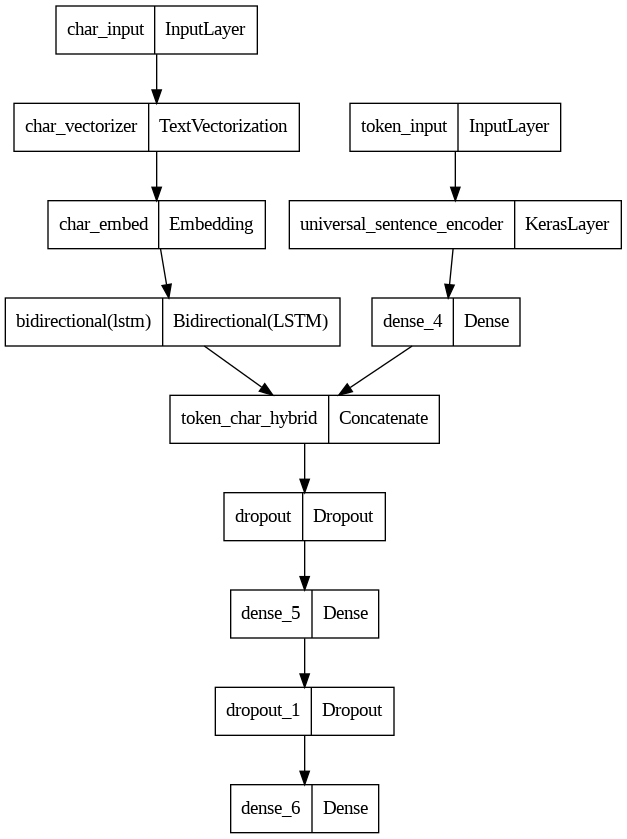

In [84]:
from keras.utils import plot_model
plot_model(model_4)

In [85]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [86]:
train_char_token_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset=tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))
train_char_token_dataset=train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# test_char_token_data=tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))
# test_char_token_labels=tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
# test_char_token_dataset=tf.data.Dataset.zip((test_char_token_data,test_char_token_labels))
# test_char_token_dataset=test_char_token_dataset.batch(32).prefetch(tf.DATA.AUTOTUNE)

val_char_token_data=tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_labels=tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset=tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))
val_char_token_dataset=val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [87]:
history_model_4=model_4.fit(train_char_token_dataset,steps_per_epoch=int(0.1*len(train_char_token_dataset)),epochs=3,validation_data=val_char_token_dataset,
                            validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 42s 55ms/step - loss: 0.9817 - accuracy: 0.6058 - val_loss: 0.7779 - val_accuracy: 0.7001
Epoch 2/3
562/562 [==============================] - 27s 48ms/step - loss: 0.8006 - accuracy: 0.6912 - val_loss: 0.7116 - val_accuracy: 0.7314
Epoch 3/3
562/562 [==============================] - 24s 43ms/step - loss: 0.7720 - accuracy: 0.7077 - val_loss: 0.6835 - val_accuracy: 0.7404


In [88]:
model_4_pred_probs=model_4.predict(val_char_token_dataset)

945/945 [==============================] - 21s 19ms/step


In [89]:
model_4_preds=tf.argmax(model_4_pred_probs,axis=1)

In [90]:
model_4_results=calculate_results(val_labels_encoded,model_4_preds)
model_4_results

{'accuracy': 73.75877134913279,
 'precision': 0.7374932381722543,
 'recall': 0.7375877134913279,
 'f1': 0.7358074024084557}

In [91]:
#model_5

In [92]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

In [93]:
val_df["line_number"].value_counts()

0     2500
1     2500
2     2500
3     2500
4     2497
5     2488
6     2461
7     2384
8     2247
9     2032
10    1699
11    1358
12    1001
13     713
14     494
15     323
16     203
17     112
18      75
19      50
20      27
21      18
22      10
23       7
24       7
25       4
26       2
Name: line_number, dtype: int64

In [94]:
test_df["line_number"].value_counts()

0     2500
1     2500
2     2500
3     2500
4     2498
5     2489
6     2458
7     2394
8     2239
9     1985
10    1679
11    1322
12     996
13     711
14     496
15     336
16     211
17     131
18      85
19      49
20      26
21      13
22       5
23       4
24       4
25       2
26       1
27       1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

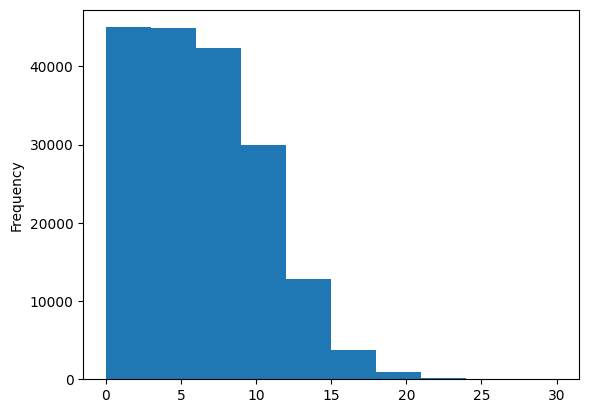

In [95]:
train_df.line_number.plot.hist()

In [96]:
train_line_numbers_one_hot=tf.one_hot(train_df["line_number"].to_numpy(),depth=30)
val_line_numbers_one_hot=tf.one_hot(val_df["line_number"].to_numpy(),depth=30)
test_line_numbers_one_hot=tf.one_hot(test_df["line_number"].to_numpy(),depth=30)

In [97]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

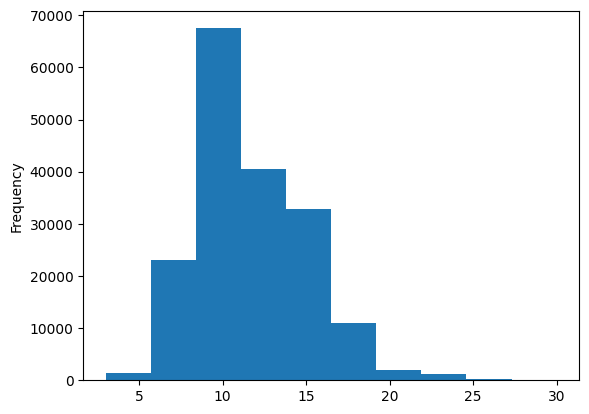

In [98]:
train_df.total_lines.plot.hist()

In [99]:
train_total_lines_one_hot=tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot=tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot=tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)

In [100]:
# 1 token embedding
token_inputs=layers.Input(shape=[],dtype=tf.string,name="token_input")
token_embeddings=tf_hub_embedding_layer(token_inputs)
token_outputs=layers.Dense(128,activation="relu")(token_embeddings)
token_model=tf.keras.Model(token_inputs,token_outputs)

#2 char embedding
char_inputs=layers.Input(shape=(1,),dtype=tf.string,name="char_input")
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(char_inputs,char_bi_lstm)

#3 line_number model
line_number_inputs=layers.Input(shape=(30,),dtype=tf.float32,name="line_number_input")
x=layers.Dense(128,activation="relu")(line_number_inputs)
line_number_model=tf.keras.Model(line_number_inputs,x)

#4 total_line model
total_lines_inputs=layers.Input(shape=(20,),dtype=tf.float32,name="total_lines_input")
y=layers.Dense(128,activation="relu")(total_lines_inputs)
total_line_model=tf.keras.Model(total_lines_inputs,y)

# 5 combining 1 and 2
combined_embeddings=layers.Concatenate(name="char_token_hybrid_hybrid")([token_model.output,char_model.output])
z=layers.Dense(256,activation="relu")(combined_embeddings)
z=layers.Dropout(0.5)(z)

# 6 combining 3,4,5
tribrid_embeddings=layers.Concatenate(name="char_token_positinoal_embeddings")([z,line_number_model.output,total_line_model.output])

#7create_output_layer
output_layer=layers.Dense(5,activation="softmax",name="output_layer")(tribrid_embeddings)

#8 putting it all together
model_5=tf.keras.Model(inputs=[line_number_model.input,
                               total_line_model.input,
                               token_model.input,
                               char_model.input]
                       ,outputs=output_layer)


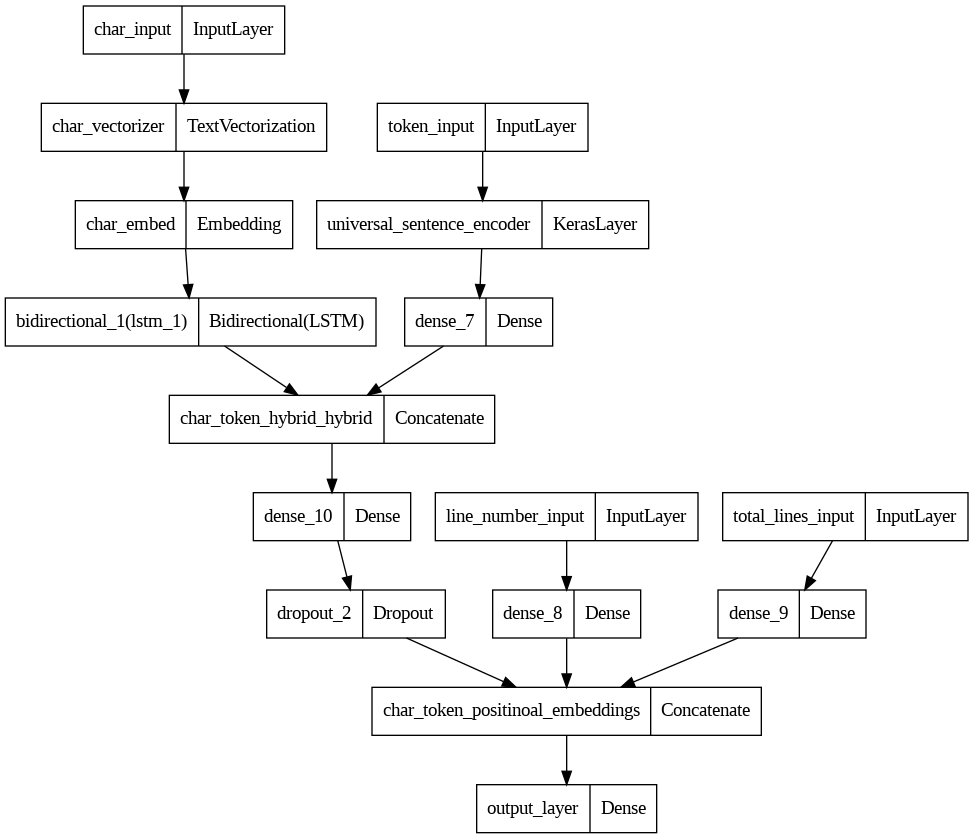

In [101]:
from keras.utils import plot_model
plot_model(model_5)

In [102]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [103]:
train_char_token_pos_data=tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,train_total_lines_one_hot,train_sentences,train_chars))
train_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset=tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))
train_char_token_pos_dataset=train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [104]:
val_char_token_pos_data=tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,val_total_lines_one_hot,val_sentences,val_chars))
val_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset=tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels))
val_char_token_pos_dataset=val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [105]:
train_char_token_pos_dataset,val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 30), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 30), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [106]:
history_model_5=model_5.fit(train_char_token_pos_dataset,steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),epochs=3,validation_data=val_char_token_pos_dataset,
                            validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 43s 57ms/step - loss: 1.0634 - accuracy: 0.7460 - val_loss: 0.9698 - val_accuracy: 0.8132
Epoch 2/3
562/562 [==============================] - 29s 51ms/step - loss: 0.9553 - accuracy: 0.8232 - val_loss: 0.9427 - val_accuracy: 0.8301
Epoch 3/3
562/562 [==============================] - 26s 46ms/step - loss: 0.9412 - accuracy: 0.8326 - val_loss: 0.9358 - val_accuracy: 0.8358


In [107]:
model_5_pred_probs=model_5.predict(val_char_token_pos_dataset,verbose=1)

945/945 [==============================] - 22s 21ms/step


In [108]:
model_5_preds=tf.argmax(model_5_pred_probs,axis=1)

In [109]:
model_5_results=calculate_results(val_labels_encoded,model_5_preds)
model_5_results

{'accuracy': 83.80113862041573,
 'precision': 0.8369782338339847,
 'recall': 0.8380113862041573,
 'f1': 0.8373230215022819}

In [111]:
model_6=tf.keras.Model(inputs=[line_number_model.input,
                               total_line_model.input,
                               token_model.input,
                               char_model.input]
                       ,outputs=output_layer)

In [113]:
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [114]:
history_model_6=model_6.fit(train_char_token_pos_dataset,epochs=3,validation_data=val_char_token_pos_dataset,
                            validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
5627/5627 [==============================] - 311s 53ms/step - loss: 0.9152 - accuracy: 0.8509 - val_loss: 0.9065 - val_accuracy: 0.8491
Epoch 2/3
5627/5627 [==============================] - 262s 47ms/step - loss: 0.9008 - accuracy: 0.8606 - val_loss: 0.9028 - val_accuracy: 0.8494
Epoch 3/3
5627/5627 [==============================] - 260s 46ms/step - loss: 0.8910 - accuracy: 0.8675 - val_loss: 0.9015 - val_accuracy: 0.8471


In [115]:
model_6_pred_probs=model_6.predict(val_char_token_pos_dataset,verbose=1)

945/945 [==============================] - 22s 19ms/step


In [116]:
model_6_preds=tf.argmax(model_6_pred_probs,axis=1)

In [117]:
model_6_results=calculate_results(val_labels_encoded,model_6_preds)
model_6_results

{'accuracy': 85.71097577121674,
 'precision': 0.859294535522224,
 'recall': 0.8571097577121674,
 'f1': 0.8540006969678919}

In [118]:
# compare model results

In [119]:

# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results,
                                  "tribrid_pos_char_token_embed_with_full(20k_data)":model_6_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.647557,0.783253,0.786476,0.783937
pretrained_token_embed,71.359063,0.713861,0.713591,0.710463
custom_char_embed_conv1d,67.757845,0.681483,0.677578,0.666845
hybrid_char_token_embed,73.758771,0.737493,0.737588,0.735807
tribrid_pos_char_token_embed,83.801139,0.836978,0.838011,0.837323
tribrid_pos_char_token_embed_with_full(20k_data),85.710976,0.859295,0.857110,0.854001


In [120]:
all_model_results["accuracy"]=all_model_results["accuracy"]/100

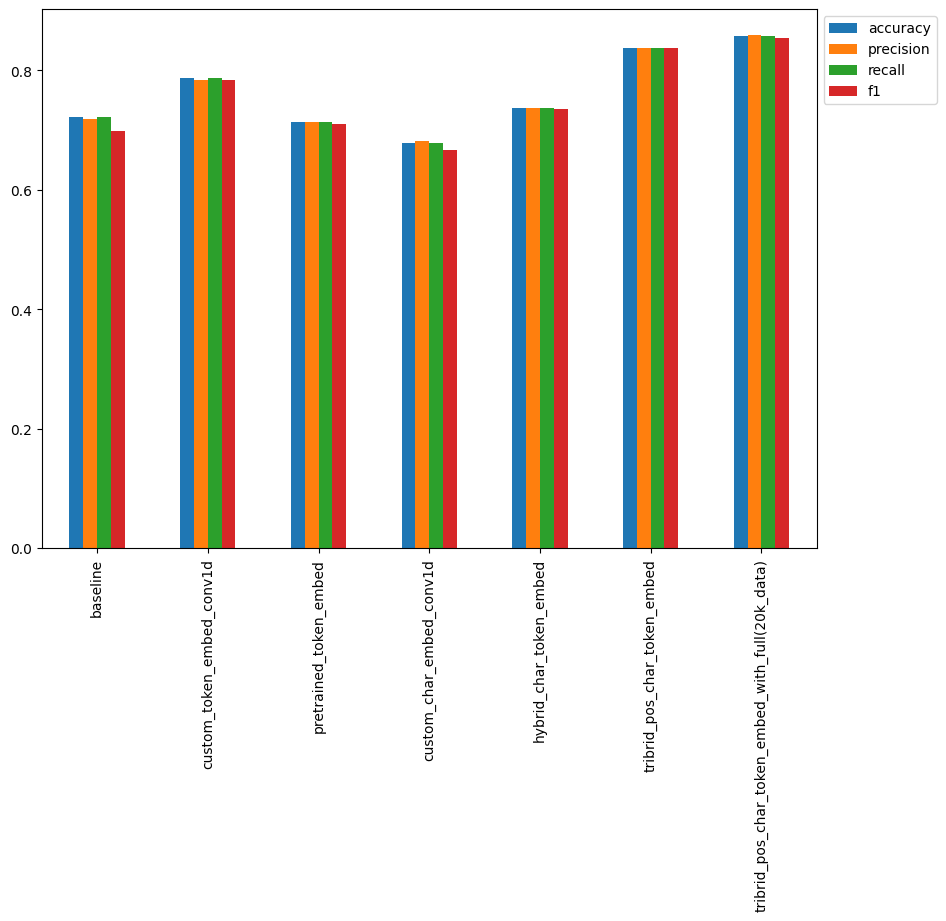

In [121]:
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

<Axes: >

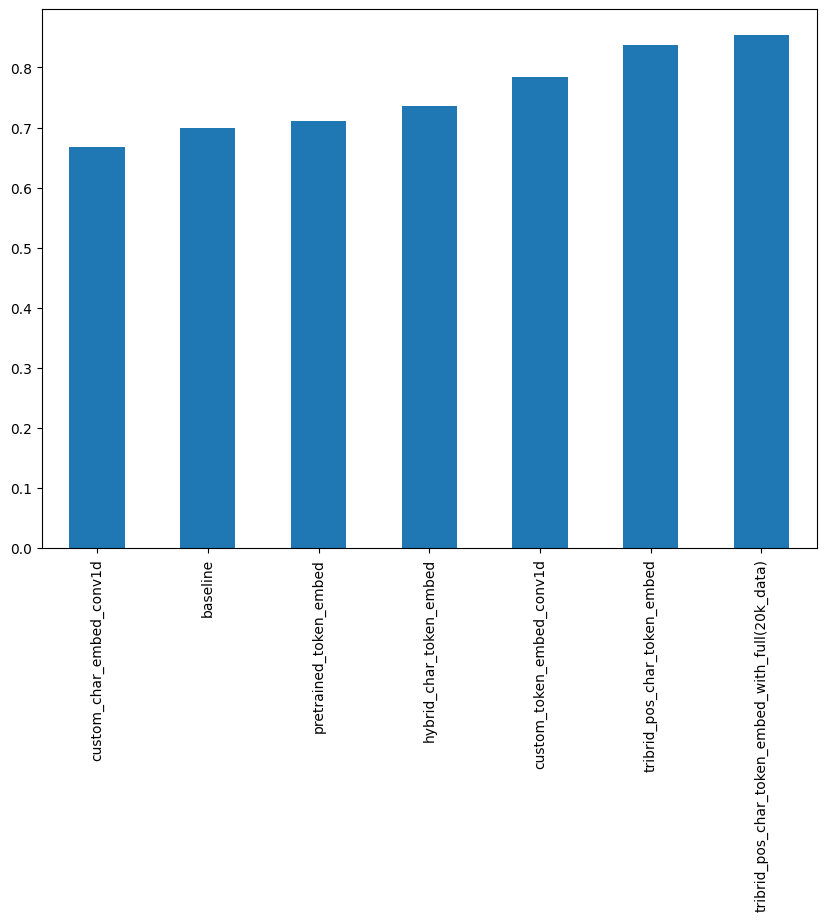

In [122]:
all_model_results.sort_values("f1",ascending=True)["f1"].plot(kind="bar",figsize=(10,7))

In [123]:
# save and load model

In [124]:
model_5.save("skimlit_tribrid_model")

In [125]:
loaded_model=tf.keras.models.load_model("skimlit_tribrid_model")

In [126]:
loaded_preds_probs=loaded_model.predict(val_char_token_pos_dataset)
loaded_preds=tf.argmax(loaded_preds_probs,axis=1)

945/945 [==============================] - 22s 21ms/step


In [127]:
loaded_model_results=calculate_results(val_labels_encoded,loaded_preds)
loaded_model_results

{'accuracy': 85.71097577121674,
 'precision': 0.859294535522224,
 'recall': 0.8571097577121674,
 'f1': 0.8540006969678919}

In [128]:
# evaluating on test data

In [129]:
test_char_token_pos_data=tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,test_total_lines_one_hot,test_sentences,test_chars))
test_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset=tf.data.Dataset.zip((test_char_token_pos_data,test_char_token_pos_labels))
test_char_token_pos_dataset=test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [130]:
model_5_pred_probs_on_test=model_5.evaluate(test_char_token_pos_dataset,verbose=1)

942/942 [==============================] - 21s 22ms/step - loss: 0.9037 - accuracy: 0.8522


In [131]:
model_5_pred_probs_on_test_1=model_5.predict(test_char_token_pos_dataset,verbose=1)

942/942 [==============================] - 18s 19ms/step


In [133]:
test_preds = tf.argmax(model_5_pred_probs_on_test_1, axis=1)

In [134]:
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 85.22316243570599,
 'precision': 0.8532809702502191,
 'recall': 0.8522316243570599,
 'f1': 0.8489757906858146}

In [135]:
# finding most wrong

In [136]:
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]

In [137]:
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(model_5_pred_probs_on_test_1, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.424070,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.556047,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.831916,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.751787,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.772026,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.837234,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.743446,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.652927,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.760239,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.662663,True


In [138]:
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
8545,METHODS,pretest-posttest .,1,11,BACKGROUND,0.954405,False
13874,CONCLUSIONS,symptom outcomes will be assessed and estimate...,4,6,METHODS,0.947563,False
2755,CONCLUSIONS,"overall , the intervention enhanced health at ...",6,8,RESULTS,0.945613,False
16580,OBJECTIVE,"second , we collected patient-reported outcome...",4,27,METHODS,0.933210,False
22736,OBJECTIVE,"the national institute of oncology , budapest ...",4,20,METHODS,0.930010,False
...,...,...,...,...,...,...,...
10137,RESULTS,this two-group online individually randomised ...,4,14,METHODS,0.860549,False
30088,RESULTS,the presence of isa was assessed in the oct im...,2,7,METHODS,0.860435,False
14326,METHODS,a total of @ volunteer subjects were randomize...,6,13,RESULTS,0.859986,False
1458,RESULTS,control group was allocated to usual-care .,3,12,METHODS,0.859772,False


In [139]:
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: METHODS, Pred: BACKGROUND, Prob: 0.9544050693511963, Line number: 1, Total lines: 11

Text:
pretest-posttest .

-----

Target: CONCLUSIONS, Pred: METHODS, Prob: 0.9475627541542053, Line number: 4, Total lines: 6

Text:
symptom outcomes will be assessed and estimates of cost-effectiveness made .

-----

Target: CONCLUSIONS, Pred: RESULTS, Prob: 0.9456130266189575, Line number: 6, Total lines: 8

Text:
overall , the intervention enhanced health at an individual level and favored social network diversity at a group level .

-----

Target: OBJECTIVE, Pred: METHODS, Prob: 0.9332098960876465, Line number: 4, Total lines: 27

Text:
second , we collected patient-reported outcomes for balance confidence and falls control .

-----

Target: OBJECTIVE, Pred: METHODS, Prob: 0.9300099611282349, Line number: 4, Total lines: 20

Text:
the national institute of oncology , budapest conducted a single centre randomized clinical study .

-----

Target: BACKGROUND, Pred: OBJECTIVE, Prob: 0.92245519